In [ ]:
!pip install --upgrade h5py==2.10.0

     |████████████████████████████████| 2.9 MB 8.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/pysource7/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
%tensorflow_version 1.x
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import shutil
import zipfile
import tensorflow as tf

TensorFlow 1.x selected.


In [ ]:
sys.path.append('/content/Mask_RCNN/')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from PIL import Image, ImageDraw
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/datandcode.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/Mask_RCNN.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/')

In [ ]:
import numpy as np
sys.path.append("/content/Mask_RCNN/samples/coco/")
import mrcnn.model as model_mask_lib
from mrcnn import visualize
from mrcnn.config import Config
import imgaug
from pycocotools import mask
from coco import CocoDataset
from coco import CocoConfig
%load_ext autoreload
%autoreload 2

In [ ]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
import mrcnn.visualize
from mrcnn.model import log
import skimage
from skimage.filters import threshold_mean
from skimage.color import rgb2gray, gray2rgb

In [ ]:
dataset_train = CocoDataset()
dataset_train.load_coco("/content/datandcode/train-val", "train", year=2018, return_coco=True, auto_download=False)
dataset_train.prepare()

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [ ]:
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 193
Class Count: 2
  0. BG                                                
  1. tooth                                             


In [ ]:
dataset_val = CocoDataset()
dataset_val.load_coco("/content/datandcode/train-val", "train", year=2018, return_coco=True, auto_download=False)
dataset_val.prepare()

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [ ]:
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 193
Class Count: 2
  0. BG                                                
  1. tooth                                             


In [ ]:
dataset_test = CocoDataset()
dataset_test.load_coco("/content/datandcode/test", "test",  year=2018, return_coco=True, auto_download=False)
dataset_test.prepare()

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


In [ ]:
print("Image Count: {}".format(len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 1224
Class Count: 2
  0. BG                                                
  1. tooth                                             


(35, 4)


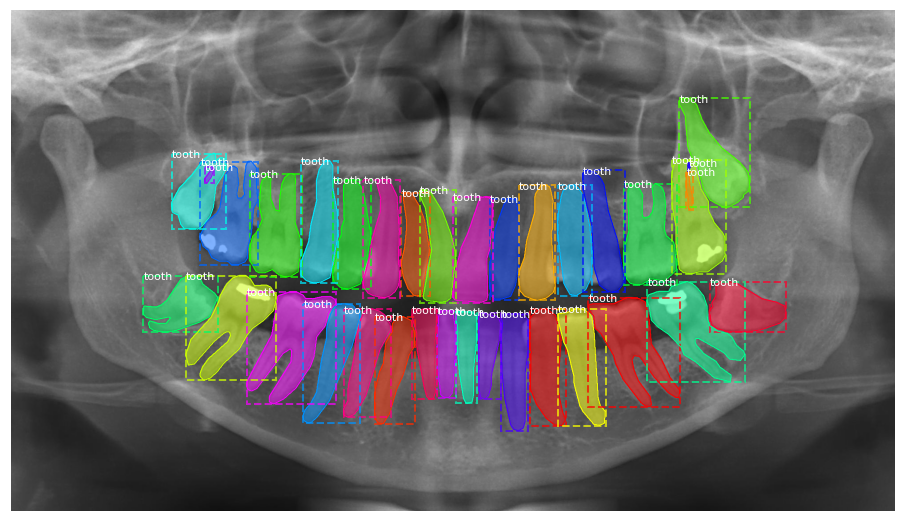

(29, 4)


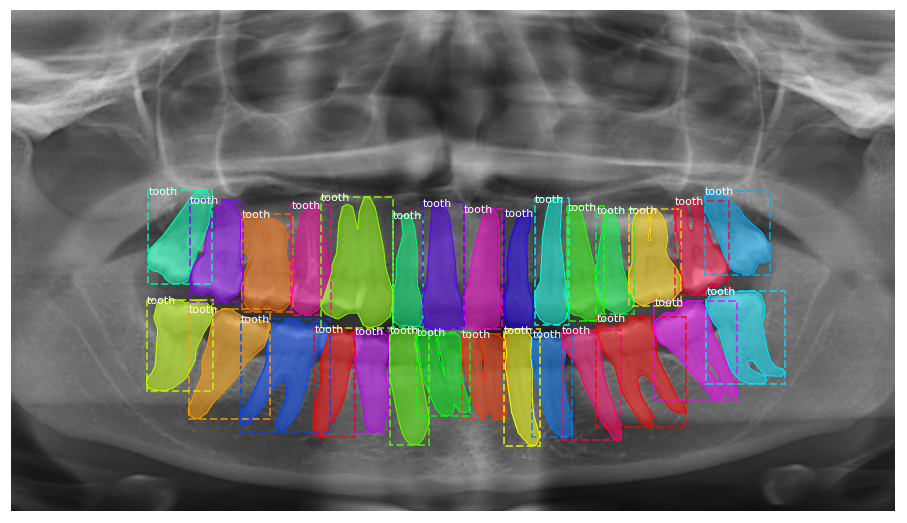

(37, 4)


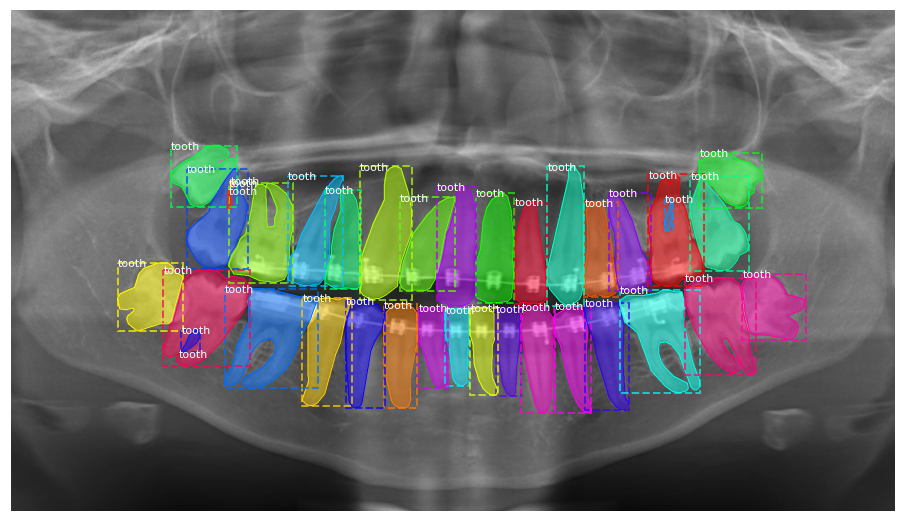

(33, 4)


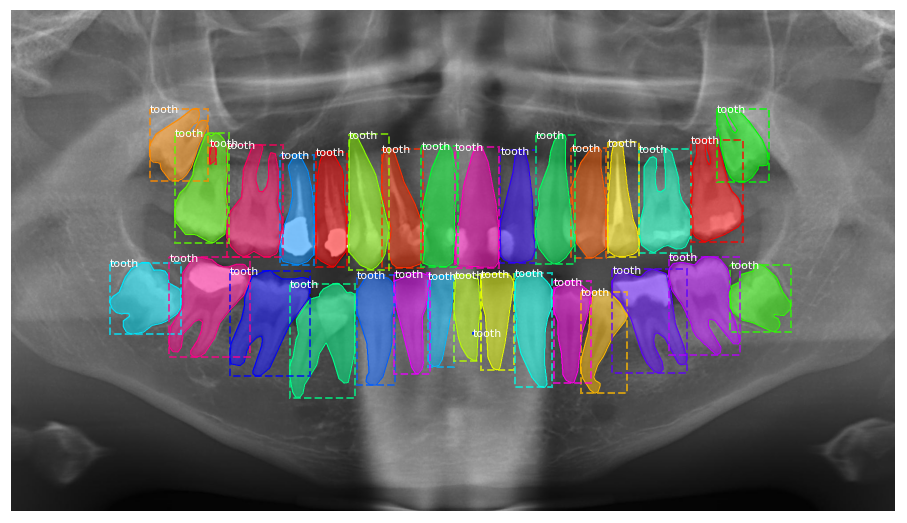

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
#image_ids = np.hstack((image_ids, dataset_train.image_ids[:4]))
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    print(bbox.shape)
    visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [ ]:
class Config_Teeth(Config):
  def __init__(self):
    super().__init__()
  NAME = "teeth_train"
  GPU_COUNT = 1
  IMAGES_PER_GPU = 4
  NUM_CLASSES = 1+1
  IMAGE_MAX_DIM = 512
  IMAGE_MIN_DIM = 512
  STEPS_PER_EPOCH = 500
  DETECTION_MIN_CONFIDENCE = 0.9

train_config = Config_Teeth()
train_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
class inference_config(Config_Teeth):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

inf_config = inference_config()
inf_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
model = model_mask_lib.MaskRCNN(mode='training',config=train_config,model_dir="/content/backup")

In [ ]:
model.load_weights('/content/drive/MyDrive/mask_rcnn_coco.h5', by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(dataset_train, dataset_train, 
            learning_rate=train_config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/backup/teeth_train20210922T0408/mask_rcnn_teeth_train_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_

In [ ]:
model1 = model_mask_lib.MaskRCNN(mode='inference',config=inf_config,model_dir="/contents/backup")

In [ ]:
model1.load_weights('/content/backup/teeth_train20210922T0408/mask_rcnn_teeth_train_0005.h5',by_name=True)

Re-starting from epoch 5


In [ ]:
import random
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inf_config, 
                           image_id)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


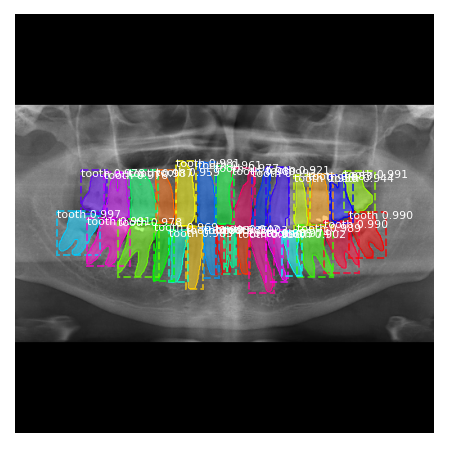

In [ ]:
import matplotlib.pyplot as plt
results = model1.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image,r['rois'], r['masks'], 
                            r['class_ids'], 
                            dataset_test.class_names, r['scores'],ax=get_ax())